In [2]:
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
import glob
from IPython.display import Audio, display
import numpy as np
import torchaudio
import torch
from pydub import AudioSegment
from torchmetrics.audio import ScaleInvariantSignalDistortionRatio
import matplotlib.pyplot as plt

In [62]:
from torch import tensor

# path = "/data/ephraim/output/Enhanced/mode_output/datasets_16k/noisy_testset_wav/p232_001.wav"
# path = "/data/ephraim/datasets_16k/noisy_testset_wav/p232_072.wav"
# cd_path = "/data/ephraim/output/Enhanced/pretrained_base/model370200/test/voicebank_Noisy_Test/p232_072.wav"

target_path = "/data/ephraim/datasets_16k/clean_testset_wav/p232_010.wav"
cd_path = "/data/ephraim/output/Enhanced/pretrained_base/model370200/test/voicebank_Noisy_Test/p232_010.wav"
other_path = "/data/ephraim/datasets_16k/clean_testset_wav/p232_072.wav"

target, sr = torchaudio.load(target_path)
preds, sr = torchaudio.load(cd_path)
other, sr = torchaudio.load(other_path)
print(other.shape)
si_sdr = ScaleInvariantSignalDistortionRatio()
print(si_sdr(preds, target))

if preds.shape[1] < other.shape[1]:
    other = other[:, : preds.shape[1]]
else:
    preds = preds[:, : other.shape[1]]
print(si_sdr(preds, other))

torch.Size([1, 31799])
tensor(9.0276)
tensor(-30.8539)


In [59]:
preds.shape

torch.Size([1, 1])

In [54]:
# path = "/data/ephraim/output/Enhanced/mode_output/datasets_16k/noisy_testset_wav/p232_001.wav"
# path = "/data/ephraim/datasets_16k/noisy_testset_wav/p232_072.wav"
# cd_path = "/data/ephraim/output/Enhanced/pretrained_base/model370200/test/voicebank_Noisy_Test/p232_072.wav"

target_path = "/data/ephraim/datasets_16k/clean_testset_wav/p232_010.wav"
cd_path = "/data/ephraim/output/Enhanced/pretrained_base/model370200/test/voicebank_Noisy_Test/p232_010.wav"

target, sr = torchaudio.load(target_path)
preds, sr = torchaudio.load(cd_path)
print(si_sdr(target, target))
with torch.enable_grad():
    preds = preds.detach().requires_grad_(True)
    si_sdr = ScaleInvariantSignalDistortionRatio()
    sisdr_score = si_sdr(preds, target)
    gradient = torch.autograd.grad(sisdr_score, preds)[0]
print(gradient)

tensor(93.2638)
tensor([[0.0077, 0.0128, 0.0094,  ..., 0.0065, 0.0077, 0.0064]])


In [46]:
alpha = [1,2,3]
for n in range(len(alpha) - 1, -1, -1):
    print(n)

2
1
0


In [47]:
np.zeros(len(alpha))

array([0., 0., 0.])

In [45]:
import socketserver
with socketserver.TCPServer(('localhost', 0), None) as s:
    print(s.server_address[1])

36587


In [32]:
inference_noise_schedule1 = [0.0001, 0.001, 0.01, 0.05, 0.2, 0.35]
inference_noise_schedule_linear = np.linspace(1e-4, 0.35, 18).tolist()
inference_noise_schedule2 = [0.0001, 0.001, 0.01, 0.05, 0.2, 0.35]

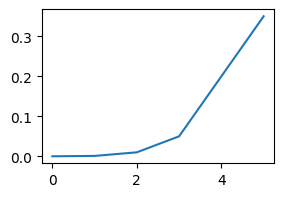

In [33]:
plt.figure(figsize=(3, 2))
plt.plot(inference_noise_schedule1)

[0.0001, 0.00016161236692075162, 0.0002611855714172765, 0.00042210818402295066, 0.0006821790271656924, 0.0011024856724394317, 0.0017817531901915319, 0.0028795335033545326, 0.0046536822510473055, 0.007520926034888457, 0.01215474657934227, 0.019643573640094135, 0.031746444307576976, 0.05130618005865337, 0.08291713196941237, 0.13400433955857055, 0.21656758493712697, 0.35]


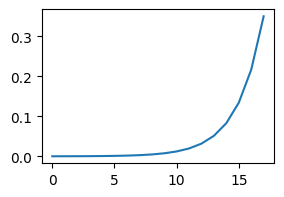

In [36]:
inference_noise_schedule_log = np.logspace(np.log10(1e-4), np.log10(0.35), 18).tolist()
plt.figure(figsize=(3, 2))
plt.plot(inference_noise_schedule_log)
print(inference_noise_schedule_log)

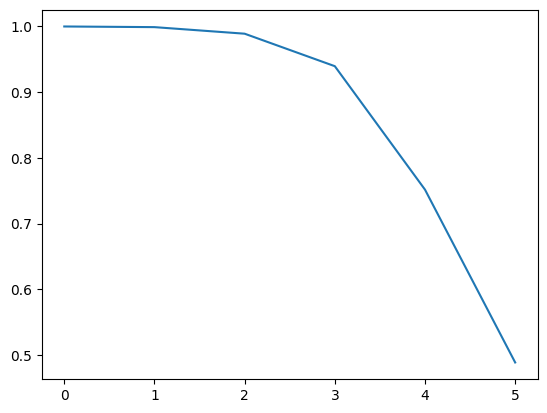

In [37]:
alpha = 1 - np.array(inference_noise_schedule1)
alpha_cum = np.cumprod(alpha)
plt.plot(alpha_cum)

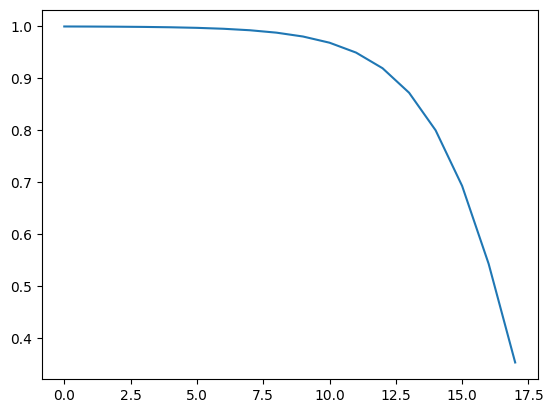

In [38]:
alpha = 1 - np.array(inference_noise_schedule_log)
alpha_cum = np.cumprod(alpha)
plt.plot(alpha_cum)

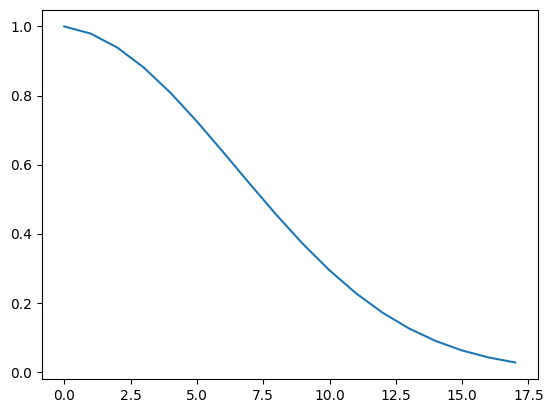

In [40]:
alpha = 1 - np.array(inference_noise_schedule_linear)
alpha_cum = np.cumprod(alpha)
plt.plot(alpha_cum)

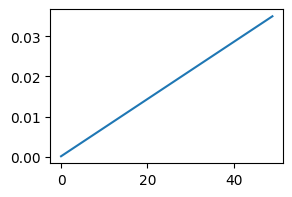

In [10]:
plt.figure(figsize=(3, 2))
plt.plot(inference_noise_schedule_linear)

In [44]:
noise_schedule = np.linspace(1e-4, 0.035, 50).tolist()
# inference_noise_schedule=[0.0001, 0.001, 0.01, 0.05, 0.2, 0.35],
inference_noise_schedule = [
    0.0001,
    0.0005,
    0.001,
    0.005,
    0.01,
    0.025,
    0.05,
    0.125,
    0.2,
    0.275,
    0.35,
]

fast_sampling = False
training_noise_schedule = np.array(noise_schedule)
inference_noise_schedule = (
    np.array(inference_noise_schedule) if fast_sampling else training_noise_schedule
)

talpha = 1 - training_noise_schedule
talpha_cum = np.cumprod(talpha)

beta = inference_noise_schedule
alpha = 1 - beta
alpha_cum = np.cumprod(alpha)
# print("beta",beta)
# print("alpha_cum",talpha_cum)
# print("gamma_cum",alpha_cum)
sigmas = [0 for i in alpha]
for n in range(len(alpha) - 1, -1, -1):
    sigmas[n] = (1.0 - alpha_cum[n - 1]) / (1.0 - alpha_cum[n]) * beta[n]

T = []
for s in range(len(inference_noise_schedule)):
    for t in range(len(training_noise_schedule) - 1):
        print(talpha_cum[t + 1], alpha_cum[s], talpha_cum[t])
        if talpha_cum[t + 1] <= alpha_cum[s] <= talpha_cum[t]:
            twiddle = (talpha_cum[t] ** 0.5 - alpha_cum[s] ** 0.5) / (
                talpha_cum[t] ** 0.5 - talpha_cum[t + 1] ** 0.5
            )
            T.append(t + twiddle)
            break
T = np.array(T, dtype=np.float32)
print("len(T): ", len(T))
print("len(alpha): ", len(alpha))
print("len(inference_noise_schedule): ", len(inference_noise_schedule))

0.9990878363265306 0.9999 0.9999
0.9990878363265306 0.9990878363265306 0.9999
0.9990878363265306 0.9975647371148247 0.9999
0.9975647371148247 0.9975647371148247 0.9990878363265306
0.9990878363265306 0.9953334494579312 0.9999
0.9975647371148247 0.9953334494579312 0.9990878363265306
0.9953334494579312 0.9953334494579312 0.9975647371148247
0.9990878363265306 0.9923982314284073 0.9999
0.9975647371148247 0.9923982314284073 0.9990878363265306
0.9953334494579312 0.9923982314284073 0.9975647371148247
0.9923982314284073 0.9923982314284073 0.9953334494579312
0.9990878363265306 0.9887648387198715 0.9999
0.9975647371148247 0.9887648387198715 0.9990878363265306
0.9953334494579312 0.9887648387198715 0.9975647371148247
0.9923982314284073 0.9887648387198715 0.9953334494579312
0.9887648387198715 0.9887648387198715 0.9923982314284073
0.9990878363265306 0.9844405059660416 0.9999
0.9975647371148247 0.9844405059660416 0.9990878363265306
0.9953334494579312 0.9844405059660416 0.9975647371148247
0.99239823142

In [7]:
# path = "/data/ephraim/output/Enhanced/mode_output/datasets_16k/noisy_testset_wav/p232_001.wav"
# path = "/data/ephraim/datasets_16k/noisy_testset_wav/p232_072.wav"
# cd_path = "/data/ephraim/output/Enhanced/pretrained_base/model370200/test/voicebank_Noisy_Test/p232_072.wav"

path = "/data/ephraim/datasets_16k/noisy_testset_wav/p232_010.wav"
cd_path = "/data/ephraim/output/Enhanced/pretrained_base/model370200/test/voicebank_Noisy_Test/p232_010.wav"
display(Audio(path, rate=16000, autoplay=False))

In [4]:

WAVEFORM, SAMPLE_RATE_enhanced = torchaudio.load(cd_path3)
WAVEFORM[:,0:-1].shape

NameError: name 'cd_path3' is not defined

In [8]:
cd_path2 = "/data/ephraim/output/Enhanced/pretrained_base/model370200/test/voicebank_Noisy_Test/p232_072.wav"
path3 = "/data/ephraim/datasets_16k/noisy_testset_wav/p232_142.wav"
cd_path3 = "/data/ephraim/output/Enhanced/pretrained_base/model370200/test/voicebank_Noisy_Test/p232_142.wav"

WAVEFORM, SAMPLE_RATE_enhanced = torchaudio.load(cd_path3)
if int(WAVEFORM.shape[1]) % 2:
    WAVEFORM = WAVEFORM[:, 0:-1]
out = (WAVEFORM.cpu().numpy().flatten() * 2**15).astype(np.int16)
print(WAVEFORM.shape)
print(out.shape)
print
sound = AudioSegment(out, channels=1, sample_width=2, frame_rate=16000)

noisy_audio, sr = torchaudio.load(path3)
if int(noisy_audio.shape[1]) % 2:
    noisy_audio = noisy_audio[:, 0:-1]

sound

torch.Size([1, 43424])
(43424,)


In [9]:
print(noisy_audio.shape)
# 43263

torch.Size([1, 43424])


In [10]:
from src.cdiffuse.mode import MODE
from src.cdiffuse.mode import TRANSFORMS as transform
from torch.nn import functional as F
import matplotlib.pyplot as plt

with torch.enable_grad():
    audio = WAVEFORM.detach().requires_grad_(True)
    mode_path = "/data/ephraim/mode/mode3-epoch150-no_norm-new.pth"
    mode_model = MODE(num_experts=3, output_size=512 // 2 + 1, context=10)
    mode_model.load_state_dict(torch.load(mode_path, map_location="cpu")["state_dict"])
    sig_array = (audio.cpu().detach().numpy().flatten() * 2**15).astype(np.int16)
    sig = AudioSegment(sig_array, channels=1, sample_width=2, frame_rate=16000)

    noisy_stft = transform(sig)
    noisy_stft = noisy_stft.squeeze()
    # reshape to get context
    context_noisy_stft = F.pad(noisy_stft, [0, 0] + [5, 4])
    context_noisy_stft = context_noisy_stft.unfold(dimension=0, size=10, step=1)
    context_noisy_stft.requires_grad_(True)  ###########
    out_raw, _ = mode_model(context_noisy_stft.unsqueeze(1).contiguous())
    out = out_raw
    # out = out_raw.detach().cpu().numpy()

    noisy_sig_array = (noisy_audio.cpu().numpy().flatten() * 2**15).astype(np.int16)
    noisy_sig = AudioSegment(
        noisy_sig_array,
        channels=1,
        sample_width=2,
        frame_rate=16000,
    )
    guide_stft = transform(noisy_sig)
    guide_stft = guide_stft.squeeze()
    # reshape to get context
    context_guide_stft = F.pad(guide_stft, [0, 0] + [5, 4])
    context_guide_stft = context_guide_stft.unfold(dimension=0, size=10, step=1)
    Y, _ = mode_model(context_guide_stft.unsqueeze(1).contiguous())

    out[Y < 0.5] = 1 - out[Y < 0.5]
    log_probs = torch.log(out)
    # log_probs_torch = torch.from_numpy(log_probs).detach().requires_grad_(True)
    gradient = torch.autograd.grad(log_probs.sum(), context_noisy_stft)[
        0
    ]  # , allow_unused=True

    print("gradient: ", gradient)

gradient:  tensor([[[-1.0855e+01, -1.3143e+01, -8.3120e+00,  ...,  8.1901e-01,
          -7.8783e+00, -8.7309e+00],
         [-1.0864e+01, -1.1607e+01, -8.7126e+00,  ..., -5.5180e-01,
           7.7263e-01, -5.3481e+00],
         [-1.0934e+01, -8.0472e+00,  1.0150e+00,  ...,  5.0740e+00,
          -5.5646e+00, -3.9964e+00],
         ...,
         [ 2.7712e+01,  2.4550e+01,  1.5581e+01,  ...,  1.8166e+01,
           1.6461e+01,  3.1612e+01],
         [ 3.1517e+01,  2.2687e+01,  1.4538e+01,  ...,  2.9830e+01,
           2.0164e+01,  3.0534e+01],
         [ 1.8576e+01,  6.9935e+00,  3.3884e+00,  ...,  2.3968e+01,
           1.5133e+01,  1.7725e+01]],

        [[-6.0685e+00, -8.3566e+00, -5.4354e+00,  ...,  2.7815e-02,
          -5.7619e+00, -8.7909e+00],
         [-1.0883e+01, -9.3088e+00, -8.2763e+00,  ...,  2.1700e+00,
           2.1270e+00, -3.5083e+00],
         [-4.3270e+00, -5.1245e+00,  3.6996e+00,  ...,  5.8542e+00,
          -1.6357e+00, -1.7272e+00],
         ...,
         [ 2.2

In [ ]:
torch.stft()

In [19]:
synt_win = torch.from_numpy(loadmat("/data/ephraim/mode/synt_win.mat")["synt_win"])
torch.istft(
    gradient,
    n_fft=512,
    hop_length=128,
    win_length=512,
    window=synt_win 
).shape
#RuntimeError: istft(torch.FloatTensor[336, 257, 10], window=torch.DoubleTensor{[512, 1]},
# expected the last dimension to be 2 (corresponding to real and imaginary parts), but got 10


RuntimeError: istft(torch.FloatTensor[336, 257, 10], n_fft=512, hop_length=128, win_length=512, window=torch.DoubleTensor{[512, 1]}, center=1, normalized=0, onesided=None, length=None, return_complex=0) : expected the last dimension to be 2 (corresponding to real and imaginary parts), but got 10

In [78]:
logits = classifier(x_in, t)
log_probs = F.log_softmax(logits, dim=-1)
selected = log_probs[range(len(logits)), y.view(-1)]
gradient = (torch.autograd.grad(selected.sum(), x_in)[0] * args.classifier_scale )

128

In [1]:
time_gradient = torch.istft()

NameError: name 'torch' is not defined

In [79]:
print(np.angle(-0.31516480719987516))
print(torch.angle(torch.tensor(-0.31516480719987516)))

3.141592653589793
tensor(0.)


In [15]:
from scipy.io import loadmat

noisy_audio, sr = torchaudio.load(path3)
if int(noisy_audio.shape[1]) % 2:
    noisy_audio = noisy_audio[:, 0:-1]
noisy_sig = AudioSegment(
    noisy_sig_array,
    channels=1,
    sample_width=2,
    frame_rate=16000,
)

synt_win = loadmat("/data/ephraim/mode/synt_win.mat")["synt_win"]
params = {
    # signal params
    "frame_rate": 16000,
    "sample_width": 2,
    "channels": 1,
    # spp params
    "spp_threshold": 10,  # 10 - no infuance on VAD; 100 - VAD has influnce
    "spp_vad_attenuation_factor": 0.5,  # 0.03 - default value ;
    "beta": 0.04,
    # stft params
    "nfft": 512,
    "overlap": 0.75,
    "eps": 1e-6,
    "synt_win": synt_win,
}
do_vad = True
vad_thr = 10
vad_attenuation = 0.03
beta = 0.04
stft_args = {
    "nfft": params["nfft"],
    "win_length": params["nfft"],
    "win_step": int(params["nfft"] * (1 - params["overlap"])),
    "window": torch.hann_window(params["nfft"]),
}
nfft = 512
win_length = 512
win_step = 128

noisy_stft = (
    # stft(
    #     noisy_audio / 2**15,
    #     return_complex=True,
    #     **stft_args,
    # )
    stft(
        torch.tensor(noisy_sig.get_array_of_samples()) / 2**15,
        return_complex=True,
        **stft_args,
    )
    .squeeze()
    .T
)

irm = out.T
sig_length = win_step * irm.shape[1] + win_length
s_est = torch.zeros((sig_length, 1), dtype=torch.double)
stft_size = nfft // 2 + 1

for seg in np.arange(1, irm.shape[1]):
    time_cal = (
        np.arange((seg - 1) * win_step + 1, (seg - 1) * win_step + win_length + 1) - 1
    )

    time_cal = time_cal.astype("int64")

    stft_abs = np.abs(noisy_stft[:, seg - 1]).reshape(stft_size, 1)
    stft_phase = torch.from_numpy(
        np.angle(noisy_stft[:, seg - 1]).reshape(stft_size, 1)
    )

    rho = irm[:, seg - 1].reshape(stft_size, 1)
    # a_hat = rho * stft_abs  # eq (2)
    if beta == 0:
        a_hat = rho * stft_abs  # eq (2)
    else:
        a_hat = (stft_abs**rho) * (
            (beta * stft_abs) ** (1 - rho)
        )  # adaptation of eq (3)

    a_hat[0:3] = a_hat[0:3] * 0.001
    # a_hat_inv = a_hat[::-1]
    a_hat_inv = torch.flip(a_hat, (1, 0))
    a_hat_inv = a_hat_inv[1 : stft_size - 1]
    # a_hat_full = np.append(a_hat, a_hat_inv).reshape(win_length, 1)
    a_hat_full = torch.cat((a_hat, a_hat_inv)).reshape(win_length, 1)

    # p_inv = stft_phase[::-1]
    p_inv = torch.flip(stft_phase, (1, 0))
    p_inv = p_inv[1 : stft_size - 1]
    p_full = torch.cat((stft_phase, -p_inv)).reshape(win_length, 1)

    estimated_stft = a_hat_full * torch.exp(1j * p_full)
    r1 = torch.real(torch.fft.ifft(estimated_stft.T))

    r2 = r1.T * torch.from_numpy(synt_win)
    s_est[time_cal] = s_est[time_cal] + r2
s_est = s_est.flatten() / 1.1 / torch.max(torch.abs(s_est))
# s_est = np.trim_zeros(s_est, trim="b")  # remove trailing zeros
s_est = s_est[: noisy_audio.shape[1]]

In [129]:
print(noisy_stft.shape)
print(estimated_stft.shape)

torch.Size([257, 336])
torch.Size([512, 1])


In [81]:
sound = AudioSegment((s_est.detach().cpu().numpy().flatten() * 2**15).astype(np.int16) , channels=1, sample_width=2, frame_rate=16000)

In [82]:
sound

In [97]:
# sum(sound.get_array_of_samples() - sound2.get_array_of_samples())
sum(torch.abs(
    torch.tensor(sound.get_array_of_samples())[:43262]
    - torch.tensor(sound2.get_array_of_samples())
))

tensor(22087388)

In [114]:
s_est2 = torch.zeros((sig_length, 1), dtype=torch.double)

for seg in np.arange(1, irm.shape[1]):
    time_cal = (
        np.arange((seg - 1) * win_step + 1, (seg - 1) * win_step + win_length + 1) - 1
    )

    time_cal = time_cal.astype("int64")

    # stft_abs = np.abs(noisy_stft[:, seg - 1]).reshape(stft_size, 1)
    # stft_phase = torch.from_numpy(
    #     np.angle(noisy_stft[:, seg - 1]).reshape(stft_size, 1)
    # )

    rho = irm[:, seg - 1].reshape(stft_size, 1)
    # # a_hat = rho * stft_abs  # eq (2)
    # if beta == 0:
    #     a_hat = rho * stft_abs  # eq (2)
    # else:
    #     a_hat = (stft_abs**rho) * (
    #         (beta * stft_abs) ** (1 - rho)
    #     )  # adaptation of eq (3)

    # a_hat[0:3] = a_hat[0:3] * 0.001
    # # a_hat_inv = a_hat[::-1]
    # a_hat_inv = torch.flip(a_hat, (1, 0))
    # a_hat_inv = a_hat_inv[1 : stft_size - 1]
    # # a_hat_full = np.append(a_hat, a_hat_inv).reshape(win_length, 1)
    # a_hat_full = torch.cat((a_hat, a_hat_inv)).reshape(win_length, 1)

    # # p_inv = stft_phase[::-1]
    # p_inv = torch.flip(stft_phase, (1, 0))
    # p_inv = p_inv[1 : stft_size - 1]
    # p_full = torch.cat((stft_phase, -p_inv)).reshape(win_length, 1)

    # estimated_stft = a_hat_full * torch.exp(1j * p_full)
    r1 = (torch.fft.ifft(rho.T))

    # r2 = r1.T * torch.from_numpy(synt_win)
    s_est2[time_cal] = s_est2[time_cal] + r1
s_est2 = s_est2.flatten() / 1.1 / torch.max(torch.ab1s(s_est2))
# s_est = np.trim_zeros(s_est, trim="b")  # remove trailing zeros
s_est2 = s_est2[: noisy_audio.shape[1]]

sound_ = AudioSegment(
    (s_est.detach().cpu().numpy().flatten() * 2**15).astype(np.int16),
    channels=1,
    sample_width=2,
    frame_rate=16000,
)
sound_

RuntimeError: shape mismatch: value tensor of shape [512, 257] cannot be broadcast to indexing result of shape [512, 1]

In [119]:
stft_size

257

In [116]:
s_est2[time_cal].shape

torch.Size([512, 1])

In [85]:
mode_path3 = "/data/ephraim/output/Enhanced/mode_output/datasets_16k/noisy_testset_wav/p232_142.wav"

WAVEFORM2, SAMPLE_RATE_enhanced = torchaudio.load(mode_path3)
if int(WAVEFORM2.shape[1]) % 2:
    WAVEFORM2 = WAVEFORM2[:, 0:-1]
out2 = (WAVEFORM2.cpu().numpy().flatten() * 2**15).astype(np.int16)
print(WAVEFORM2.shape)
print(out2.shape)
print
sound2 = AudioSegment(out2, channels=1, sample_width=2, frame_rate=16000)
sound2

torch.Size([1, 43262])
(43262,)


In [51]:
s_est = s_est[:noisy_audio.shape[1]]
s_est.shape

torch.Size([43425])

In [170]:
samplerate=16000
nfft=512
winlen=0.032
winstep=0.008
winstep * samplerate

128.0

339.25

In [13]:
with torch.enable_grad():
    audio = WAVEFORM.detach().requires_grad_(True)
    mode_path = "/data/ephraim/mode/mode3-epoch150-no_norm-new.pth"
    mode_model = MODE(num_experts=3, output_size=512 // 2 + 1, context=10)
    mode_model.load_state_dict(torch.load(mode_path, map_location="cpu")["state_dict"])
    # sig_array = (audio.cpu().detach().numpy().flatten() * 2**15).astype(np.int16)
    # sig = AudioSegment(sig_array, channels=1, sample_width=2, frame_rate=16000)

    noisy_stft = transform(sig)
    noisy_stft = noisy_stft.squeeze()
    # reshape to get context
    context_noisy_stft = F.pad(noisy_stft, [0, 0] + [5, 4])
    context_noisy_stft = context_noisy_stft.unfold(dimension=0, size=10, step=1)
    context_noisy_stft.requires_grad_(True)  ###########
    out_raw, _ = mode_model(context_noisy_stft.unsqueeze(1).contiguous())
    out = out_raw
    # out = out_raw.detach().cpu().numpy()

    noisy_sig_array = (noisy_audio.cpu().numpy().flatten() * 2**15).astype(np.int16)
    noisy_sig = AudioSegment(
        noisy_sig_array,
        channels=1,
        sample_width=2,
        frame_rate=16000,
    )
    guide_stft = transform(noisy_sig)
    guide_stft = guide_stft.squeeze()
    # reshape to get context
    context_guide_stft = F.pad(guide_stft, [0, 0] + [5, 4])
    context_guide_stft = context_guide_stft.unfold(dimension=0, size=10, step=1)
    Y, _ = mode_model(context_guide_stft.unsqueeze(1).contiguous())

    out[Y < 0.5] = 1 - out[Y < 0.5]
    log_probs = torch.log(out)
    # log_probs_torch = torch.from_numpy(log_probs).detach().requires_grad_(True)
    gradient = torch.autograd.grad(log_probs.sum(), context_noisy_stft)[
        0
    ]  # , allow_unused=True
    print("gradient: ", gradient)

gradient:  tensor([[[-1.0855e+01, -1.3143e+01, -8.3120e+00,  ...,  8.1901e-01,
          -7.8783e+00, -8.7309e+00],
         [-1.0864e+01, -1.1607e+01, -8.7126e+00,  ..., -5.5180e-01,
           7.7263e-01, -5.3481e+00],
         [-1.0934e+01, -8.0472e+00,  1.0150e+00,  ...,  5.0740e+00,
          -5.5646e+00, -3.9964e+00],
         ...,
         [ 2.7712e+01,  2.4550e+01,  1.5581e+01,  ...,  1.8166e+01,
           1.6461e+01,  3.1612e+01],
         [ 3.1517e+01,  2.2687e+01,  1.4538e+01,  ...,  2.9830e+01,
           2.0164e+01,  3.0534e+01],
         [ 1.8576e+01,  6.9935e+00,  3.3884e+00,  ...,  2.3968e+01,
           1.5133e+01,  1.7725e+01]],

        [[-6.0685e+00, -8.3566e+00, -5.4354e+00,  ...,  2.7815e-02,
          -5.7619e+00, -8.7909e+00],
         [-1.0883e+01, -9.3088e+00, -8.2763e+00,  ...,  2.1700e+00,
           2.1270e+00, -3.5083e+00],
         [-4.3270e+00, -5.1245e+00,  3.6996e+00,  ...,  5.8542e+00,
          -1.6357e+00, -1.7272e+00],
         ...,
         [ 2.2

In [ ]:
#the accurate stft - for finding inverse


In [122]:
transforms = Compose(
    [
        CevaAudioSegment2Wave(byte_to_float=True),
        CevaToTensor(),
        CevaSpectogram(
            params["frame_rate"],
            params["nfft"],
            params["nfft"] / params["frame_rate"],
            (params["nfft"] * (1 - params["overlap"])) / params["frame_rate"],
            "hann",
        ),
        CevaLogMel(),
    ]
)

(342, 257)

In [14]:
class CevaSpectogram(object):
    """
    Crate a spectogram from tensor audio signal shape (batch, time).
    Args:
            samplerate (int, default=16000): Hz.
            nfft (int, default=512): number of bins in STFT.
            winlen (float, default=0.025): window len in sec.
            winstep (float, default=0.01): window stride in sec.
            window_func (str, optional): A function to create a window tensor ('hann', 'hamming' or None).
    Returns:
            Power of STFT signal tensor shape (batch, freq, time) where freq is `nfft // 2 + 1`.
    """

    def __init__(
        self,
        samplerate=16000,
        nfft=512,
        winlen=0.032,
        winstep=0.008,
        window_func="hann",
        **kwargs,
    ):
        self._nfft = nfft
        self._sr = samplerate
        # window length in samples
        self._winlen_samp = int(winlen * samplerate)
        # window step in samples
        self._winstep_samp = int(winstep * samplerate)
        if window_func == "hann":
            self._window_func = torch.hann_window(int(samplerate * winlen))
        elif window_func == "hamming":
            self._window_func = torch.hamming_window(int(samplerate * winlen))
        else:
            self._window_func = None

    def __call__(self, sig):
        magnitude_specturm = stft(
            sig,
            self._nfft,
            self._winlen_samp,
            self._winstep_samp,
            window=self._window_func,
            return_complex=False,
        )
        return magnitude_specturm


def stft(input, nfft, win_length, win_step, window=None, return_complex=False):
    """
    The STFT computes the Fourier transform of short overlapping windows of the input.
    This giving frequency components of the signal as they change over time.

    Args:
            input (Tensor): 1D time sequence signal tensor.
            nfft (int): size of Fourier transform.
            win_length (int): the size of window frame and STFT filter.
            win_step (int): the distance between neighboring sliding window frames.
            window (Tensor, optional): the optional window function.
            return_complex (bool, default=False): Whether to return magnitude or complex tensor.

    Returns:
            A tensor containing the STFT result (complex or magnitude).
    """
    from torch.fft import rfft

    wsig = input.unfold(0, win_length, win_step)

    if window is not None:
        wsig = torch.mul(wsig, window)

    padded_wsig = F.pad(wsig, [0, nfft - win_length], mode="constant", value=0)
    padded_wsig = padded_wsig.view(padded_wsig.shape[0], 1, padded_wsig.shape[1])
    fft_complex = rfft(padded_wsig)
    if return_complex:
        return fft_complex
    return fft_complex.abs()

In [ ]:
class CevaLogMel(object):
    """
    Apply log on mel filterbanks tensor.
    """

    def __init__(self, **kwargs):
        pass

    def __call__(self, mel_filter):
        log_mel_filter = torch.log10(mel_filter + 1e-10)
        return log_mel_filter

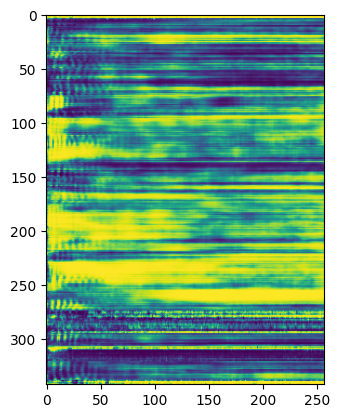

In [48]:
plt.imshow(out)

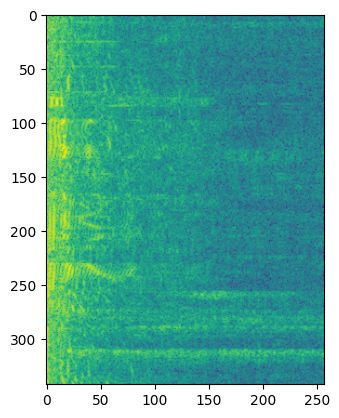

In [49]:
plt.imshow(noisy_stft)

In [39]:
from pesq import pesq
from pystoi import stoi
import numpy
import os
import pickle
from tqdm import tqdm
import torch
import torchaudio
import pandas as pd
import numpy as np
import torchaudio.functional as F


reference = "/data/ephraim/datasets_16k/clean_testset_wav/p232_011.wav"
test_noisy = "/data/ephraim/datasets_16k/noisy_testset_wav/p232_011.wav"
test_enhanced = "/data/ephraim/output/Enhanced/mode_output_float/datasets_16k/noisy_testset_wav/p232_011.wav"
WAVEFORM_SPEECH, SAMPLE_RATE_SPEECH = torchaudio.load(reference)
WAVEFORM_NOISE, SAMPLE_RATE_NOISE = torchaudio.load(test_noisy)
WAVEFORM_enhanced, SAMPLE_RATE_enhanced = torchaudio.load(test_enhanced)
print("Computing scores for ", reference)


print(WAVEFORM_SPEECH[0].numpy().shape)
print(WAVEFORM_enhanced[0].numpy().shape)

print(WAVEFORM_SPEECH[0].numpy().shape)
print(WAVEFORM_enhanced[0].numpy().shape)
pesq_noise = pesq(
    16000,
    WAVEFORM_SPEECH[0].numpy(),
    WAVEFORM_NOISE[0].numpy(),
    mode="wb",
)
stoi_noise = stoi(
    WAVEFORM_SPEECH[0].numpy(),
    WAVEFORM_NOISE[0].numpy(),
    16000,
    extended=False,
)
if WAVEFORM_SPEECH.shape[1] < WAVEFORM_enhanced.shape[1]:
    WAVEFORM_NOISE = WAVEFORM_enhanced[:, : WAVEFORM_SPEECH.shape[1]]
else:
    WAVEFORM_SPEECH = WAVEFORM_SPEECH[:, : WAVEFORM_enhanced.shape[1]]

pesq_enhanced = pesq(
    16000,
    WAVEFORM_SPEECH[0].numpy(),
    WAVEFORM_enhanced[0].numpy(),
    mode="wb",
)
stoi_enhanced = stoi(
    WAVEFORM_SPEECH[0].numpy(),
    WAVEFORM_enhanced[0].numpy(),
    16000,
    extended=False,
)
print(pesq_noise)
print(stoi_noise)

print(pesq_enhanced)
print(stoi_enhanced)

Computing scores for  /data/ephraim/datasets_16k/clean_testset_wav/p232_011.wav
(104611,)
(104446,)
(104611,)
(104446,)


2.734575033187866
0.9634774528127725
1.1166967153549194
0.5929775698002244


In [22]:

def plot(waveform, title, sample_rate=16000):
    wav_numpy = waveform.numpy()

    sample_size = waveform.shape[1]
    time_axis = torch.arange(0, sample_size) / sample_rate

    figure, axes = plt.subplots(2, 1)
    axes[0].plot(time_axis, wav_numpy[0], linewidth=1)
    axes[0].grid(True)
    axes[1].specgram(wav_numpy[0], Fs=sample_rate)
    figure.suptitle(title)

In [19]:
enhanced = "/data/ephraim/output/Enhanced/pretrained_base_guided_stoi1/model370200/voicebank_Noisy_Test/p232_083.wav"

In [24]:
plot(enhanced[0:1], f"enhanced")

AttributeError: 'str' object has no attribute 'numpy'

In [ ]:
plot(WAVEFORM_DISTORTED[0:1], f"Distorted Speech with {snr_dbs[0]}dB SNR")

In [11]:
from squim_code import SQUIM_OBJECTIVE, SQUIM_SUBJECTIVE

objective_model = SQUIM_OBJECTIVE.get_model()

ModuleNotFoundError: No module named 'squim_code'